In [1]:
import matplotlib.pyplot as plt
import numpy as np

import brainpy as bp
import brainpy.math as bm

import tqdm

from sklearn.decomposition import PCA


class AMPA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max, tau, E, label=None):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      if pre.num != post.num:
        num_min = min(pre.num, post.num)
        CONN = bp.conn.IJConn(i=np.arange(num_min), j=np.arange(num_min), pre=pre.num, post=post.num)
        comm = bp.dnn.EventCSRLinear(CONN, g_max)
      else:
        comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.Expon.desc(post.num, tau=tau)
    out = bp.dyn.COBA.desc(E=E)
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, delay=delay, comm=comm,
      syn=syn, out=out, post=post, out_label=label
    )


class NMDA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max, label=None):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      if pre.num != post.num:
        num_min = min(pre.num, post.num)
        CONN = bp.conn.IJConn(i=np.arange(num_min), j=np.arange(num_min), pre=pre.num, post=post.num)
      else:
        comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.NMDA.desc(pre.num, a=0.5, tau_decay=100., tau_rise=2.)
    out = bp.dyn.MgBlock(E=0., cc_Mg=1.0)
    self.proj = bp.dyn.ProjAlignPreMg2(
      pre=pre, delay=delay, syn=syn,
      comm=comm, out=out, post=post, out_label=label
      )

/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class DecisionMakingNet(bp.DynSysGroup):
  def __init__(self, params, scale=6, f=0.15):

    super().__init__()
    # the number of neurons in each group
    self.num_A = params['num_A']
    self.num_B = params['num_B']
    self.num_IA = params['num_IA']
    self.num_IB = params['num_IB']
    self.num_A_hb = params['num_A_hb']
    self.num_B_hb = params['num_B_hb']
    self.num_IA_hb = params['num_IA_hb']
    self.num_IB_hb = params['num_IB_hb']

    poisson_freq = 2400.  # Hz 2400
    w_pos = params['w_pos']    # 1.7  ### TODO test!!!
    
    if 'f' in params:
      f = params['f']
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = params['g_ext2E_AMPA']    # nS 1.7  ### TODO test!!!
    g_ext2I_AMPA = params['g_ext2I_AMPA']    # nS 1.62
    g_E2E_AMPA = params['g_E2E_AMPA']/scale    # nS 0.05  ### TODO test!!!
    g_E2I_AMPA = params['g_E2I_AMPA']/scale    # nS 0.05  ### TODO test!!!
    g_E2E_NMDA = params['g_E2E_NMDA']/scale    # nS 0.2  ### TODO test!!!
    g_E2I_NMDA = params['g_E2I_NMDA']/scale    # nS 0.2  ### TODO test!!!
    g_I2E_GABAa = params['g_I2E_GABAa']/scale    # nS 2.2  ### TODO test!!!
    g_I2I_GABAa = params['g_I2I_GABAa']/scale    # nS 1.0   ### TODO test!!!

    # Connection strength  ### TODO test!!!
    w_inp2AB = params['w_inp2AB'] #7
    w_inp2AB_rebound = params['w_inp2AB_rebound'] #20
    w_inp2hbAB = params['w_inp2hbAB'] #40
    w_rb_pos = params['w_rb_pos'] #50
    w_rb_neg = params['w_rb_neg'] #200

    if 'hbi_weight' in params:
      hbi_weight = params['hbi_weight']
    else:
      hbi_weight = 1

    if 'dTh2hb_weight' in params:
      dTh2hb_weight = params['dTh2hb_weight']
    else:
      dTh2hb_weight = 1

    neu_par = dict(V_rest=-70., V_reset=-55., V_th=-50., V_initializer=bp.init.OneInit(-70.))

    # E neurons/pyramid neurons
    # R is the membrane resistance R = 1 / g_L = 25 MOhm TODO: check for tau!!!
    self.A = bp.dyn.LifRef(self.num_A, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.B = bp.dyn.LifRef(self.num_B, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.hb_A = bp.dyn.LifRef(self.num_A_hb, tau=40., R=0.04, tau_ref=2., **neu_par)
    self.hb_B = bp.dyn.LifRef(self.num_B_hb, tau=40., R=0.04, tau_ref=2., **neu_par)


    # I neurons/interneurons
    self.IA = bp.dyn.LifRef(self.num_IA, tau=10., R=0.05, tau_ref=1., **neu_par)
    self.IB = bp.dyn.LifRef(self.num_IB, tau=10., R=0.05, tau_ref=1., **neu_par)
    self.hb_IA = bp.dyn.LifRef(self.num_IA_hb, tau=20., R=0.05, tau_ref=1., **neu_par)
    self.hb_IB = bp.dyn.LifRef(self.num_IB_hb, tau=20., R=0.05, tau_ref=1., **neu_par)
    
    # interneurons for rebound inhibition
    # num_IA and num_IB are the number of rebound neurons for A and B, respectively = num_A and num_B
    self.IA_rebound = bp.dyn.LifRef(self.num_A, tau=10., R=0.05, tau_ref=1., **neu_par)
    self.IB_rebound = bp.dyn.LifRef(self.num_B, tau=10., R=0.05, tau_ref=1., **neu_par)


    # noise neurons
    self.noise_A = bp.dyn.PoissonGroup(self.num_A, freqs=poisson_freq)
    self.noise_B = bp.dyn.PoissonGroup(self.num_B, freqs=poisson_freq)
    self.noise_hb_A = bp.dyn.PoissonGroup(self.num_A_hb, freqs=poisson_freq)
    self.noise_hb_B = bp.dyn.PoissonGroup(self.num_B_hb, freqs=poisson_freq)
    self.noise_IA = bp.dyn.PoissonGroup(self.num_IA, freqs=poisson_freq)
    self.noise_IB = bp.dyn.PoissonGroup(self.num_IB, freqs=poisson_freq)
    self.noise_hb_IA = bp.dyn.PoissonGroup(self.num_IA_hb, freqs=poisson_freq)
    self.noise_hb_IB = bp.dyn.PoissonGroup(self.num_IB_hb, freqs=poisson_freq)


    # define external inputs
    # poisson stimulus  
    # 'freqs' as bm.Variable
    self.Inp_A = bp.dyn.PoissonGroup(self.num_A, freqs=bm.Variable(bm.zeros(1)))
    self.Inp_B = bp.dyn.PoissonGroup(self.num_B, freqs=bm.Variable(bm.zeros(1)))   

    
    # define external inputs
    # to dTh neurons
    self.InpA2A = AMPA(self.Inp_A, self.A, 'one2one', None, g_ext2E_AMPA * w_inp2AB, tau=2., E=0.)
    self.InpB2B = AMPA(self.Inp_B, self.B, 'one2one', None, g_ext2E_AMPA * w_inp2AB, tau=2., E=0.)

    self.InpA2IA_rebound = AMPA(self.Inp_A, self.IA_rebound, 'one2one', None, g_ext2I_AMPA * w_inp2AB_rebound, tau=2., E=0.)
    self.InpB2IB_rebound = AMPA(self.Inp_B, self.IB_rebound, 'one2one', None, g_ext2I_AMPA * w_inp2AB_rebound, tau=2., E=0.)

    # to hb neurons
    self.InpA2hbA = AMPA(self.Inp_A, self.hb_A, 'one2one', None, g_ext2E_AMPA * w_inp2hbAB, tau=2., E=0., label='InpA2hb_A')
    self.InpB2hbB = AMPA(self.Inp_B, self.hb_B, 'one2one', None, g_ext2E_AMPA * w_inp2hbAB, tau=2., E=0.)


    # define AMPA projections from A
    # to dTh neurons
    self.A2B_AMPA = AMPA(self.A, self.B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.A2A_AMPA = AMPA(self.A, self.A, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.A2IA_AMPA = AMPA(self.A, self.IA, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # to hb neurons
    self.A2IA_hb_AMPA = AMPA(self.A, self.hb_IA, 'all2all', 0.5, g_E2I_AMPA * dTh2hb_weight, tau=2., E=0.)
  

    # define NMDA projections from A
    # to dTh neurons
    self.A2B_NMDA = NMDA(self.A, self.B, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.A2A_NMDA = NMDA(self.A, self.A, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.A2IA_NMDA = NMDA(self.A, self.IA, 'all2all', 0.5, g_E2I_NMDA)

    # to hb neurons
    self.A2IA_hb_NMDA = NMDA(self.A, self.hb_IA, 'all2all', 0.5, g_E2I_NMDA * dTh2hb_weight) 


    # define AMPA projections from B
    # to dTh neurons
    self.B2B_AMPA = AMPA(self.B, self.B, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.B2A_AMPA = AMPA(self.B, self.A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.B2IB_AMPA = AMPA(self.B, self.IB, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # to hb neurons
    self.B2IB_hb_AMPA = AMPA(self.B, self.hb_IB, 'all2all', 0.5, g_E2I_AMPA * dTh2hb_weight, tau=2., E=0.)


    # define NMDA projections from B
    # to dTh neurons
    self.B2B_NMDA = NMDA(self.B, self.B, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.B2A_NMDA = NMDA(self.B, self.A, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.B2IB_NMDA = NMDA(self.B, self.IB, 'all2all', 0.5, g_E2I_NMDA)

    # to hb neurons
    self.B2IB_hb_NMDA = NMDA(self.B, self.hb_IB, 'all2all', 0.5, g_E2I_NMDA * dTh2hb_weight)
      

    # define I->E/I conn
    # to dTh neurons
    self.IA2B = AMPA(self.IA, self.B, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.IB2A = AMPA(self.IB, self.A, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.IA2IA = AMPA(self.IA, self.IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.) # 0.3
    self.IB2IB = AMPA(self.IB, self.IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.) # 0.3
    self.IA2IB = AMPA(self.IA, self.IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.IB2IA = AMPA(self.IB, self.IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)

    # define I_rebound->E/I conn
    # to dTh neurons
    self.IA_rebound2A = AMPA(self.IA_rebound, self.A, 'one2one', 0.5, g_I2E_GABAa * w_rb_pos, tau=5., E=-70.)
    self.IB_rebound2B = AMPA(self.IB_rebound, self.B, 'one2one', 0.5, g_I2E_GABAa * w_rb_pos, tau=5., E=-70.)
    self.IA_rebound2B = AMPA(self.IA_rebound, self.B, 'one2one', 0.5, g_I2I_GABAa * w_rb_neg, tau=5., E=-70.)
    self.IB_rebound2A = AMPA(self.IB_rebound, self.A, 'one2one', 0.5, g_I2I_GABAa * w_rb_neg, tau=5., E=-70.)
    self.IA_rebound2IA_rebound = AMPA(self.IA_rebound, self.IA_rebound, 'one2one', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.IB_rebound2IB_rebound = AMPA(self.IB_rebound, self.IB_rebound, 'one2one', 0.5, g_I2I_GABAa, tau=5., E=-70.)  


    # define noise projections
    # to dTh neurons
    self.noise2B = AMPA(self.noise_B, self.B, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2A = AMPA(self.noise_A, self.A, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2IA = AMPA(self.noise_IA, self.IA, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)
    self.noise2IB = AMPA(self.noise_IB, self.IB, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)

    # to hb neurons
    self.noise2A_hb = AMPA(self.noise_hb_A, self.hb_A, 'one2one', None, g_ext2E_AMPA+0.005, tau=2., E=0., label='noise2hb_A')
    self.noise2B_hb = AMPA(self.noise_hb_B, self.hb_B, 'one2one', None, g_ext2E_AMPA+0.005, tau=2., E=0.)
    self.noise2IA_hb = AMPA(self.noise_hb_IA, self.hb_IA, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)
    self.noise2IB_hb = AMPA(self.noise_hb_IB, self.hb_IB, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)

    # define projections from hb_A
    # to hb neurons
    self.hb_A2hb_A_AMPA = AMPA(self.hb_A, self.hb_A, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0., label='hb_A2hb_A_AMPA')
    self.hb_A2hb_A_NMDA = NMDA(self.hb_A, self.hb_A, 'all2all', 0.5, g_E2E_NMDA * w_pos, label='hb_A2hb_A_NMDA')
    self.hb_A2hb_B_AMPA = AMPA(self.hb_A, self.hb_B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.hb_A2hb_B_NMDA = NMDA(self.hb_A, self.hb_B, 'all2all', 0.5, g_E2E_NMDA * w_neg)

    self.hb_A2hb_IB_AMPA = AMPA(self.hb_A, self.hb_IB, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)
    self.hb_A2hb_IB_NMDA = NMDA(self.hb_A, self.hb_IB, 'all2all', 0.5, g_E2I_NMDA) 

    # define projections from hb_B
    # to hb neurons
    self.hb_B2hb_B_AMPA = AMPA(self.hb_B, self.hb_B, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.hb_B2hb_B_NMDA = NMDA(self.hb_B, self.hb_B, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.hb_B2hb_A_AMPA = AMPA(self.hb_B, self.hb_A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0., label='hb_B2hb_A_AMPA')
    self.hb_B2hb_A_NMDA = NMDA(self.hb_B, self.hb_A, 'all2all', 0.5, g_E2E_NMDA * w_neg, label='hb_B2hb_A_NMDA')

    self.hb_B2hb_IA_AMPA = AMPA(self.hb_B, self.hb_IA, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)
    self.hb_B2hb_IA_NMDA = NMDA(self.hb_B, self.hb_IA, 'all2all', 0.5, g_E2I_NMDA)

    # define projections from hb_IA
    # to hb neurons
    self.hb_IA2hb_IB = AMPA(self.hb_IA, self.hb_IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    # self.hb_IA2hb_IA = AMPA(self.hb_IA, self.hb_IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.hb_IA2hb_A = AMPA(self.hb_IA, self.hb_A, 'all2all', 0.5, g_I2E_GABAa*hbi_weight, tau=5., E=-70., label='hb_IA2hb_A')

    # define projections from hb_IB
    # to hb neurons 
    self.hb_IB2hb_IA = AMPA(self.hb_IB, self.hb_IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    # self.hb_IB2hb_IB = AMPA(self.hb_IB, self.hb_IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.hb_IB2hb_B = AMPA(self.hb_IB, self.hb_B, 'all2all', 0.5, g_I2E_GABAa*hbi_weight, tau=5., E=-70.) 
     
  def update(self):
    ret = super().update()
    current_hb_B2hb_A_AMPA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_B2hb_A_AMPA')
    current_hb_B2hb_A_NMDA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_B2hb_A_NMDA')
    current_hb_IA2hb_A = self.hb_A.sum_inputs(self.hb_A.V, label='hb_IA2hb_A')
    current_InpA2hb_A = self.hb_A.sum_inputs(self.hb_A.V, label='InpA2hb_A')
    # current_noise2hb_A = self.hb_A.sum_inputs(self.hb_A.V, label='noise2hb_A')
    current_hb_A2hb_A_AMPA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_A2hb_A_AMPA')
    current_hb_A2hb_A_NMDA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_A2hb_A_NMDA')
    currents =[current_hb_B2hb_A_AMPA, current_hb_B2hb_A_NMDA, current_hb_IA2hb_A, current_InpA2hb_A, current_hb_A2hb_A_AMPA, current_hb_A2hb_A_NMDA]
    return currents


In [ ]:
class Tool:
  def __init__(self, seq):
    self.pre_stimulus_period = 100.
    self.stimulus_period = 600.
    self.delay_period = 1300.
    self.freq_variance = 1.
    self.freq_interval = 20.
    self.seq = seq
    self.total_period = len(seq) * (self.pre_stimulus_period 
                                    + self.stimulus_period + self.delay_period)

  def generate_freqs(self, R, L):
    # stimulus period 
    n_stim = int(self.stimulus_period / self.freq_interval)
    n_interval = int(self.freq_interval / bm.get_dt())
    # pre stimulus period
    freqs_pre = np.zeros(int(self.pre_stimulus_period / bm.get_dt()))
    # post stimulus period
    freqs_delay = np.zeros(int(self.delay_period / bm.get_dt()))

    for i in range(len(self.seq)):
      if self.seq[i] == 'R':
        mean = R
      else:
        mean = L
      # freqs_stim = np.random.normal(mean, self.freq_variance, (n_stim, 1))
      # change the stim freqs into the form of a ramp then a drop
      freqs_stim1 = np.linspace(0, mean, n_stim//2).reshape(-1, 1) + np.random.normal(0, self.freq_variance, (n_stim//2, 1))
      freqs_stim2 = np.linspace(mean, 0, n_stim-n_stim//2).reshape(-1, 1) + np.random.normal(0, self.freq_variance, (n_stim-n_stim//2, 1))
      freqs_stim = np.concatenate([freqs_stim1, freqs_stim2], axis=0)

      freqs_stim = np.tile(freqs_stim, (1, n_interval)).flatten()
      one_freqs = np.concatenate([freqs_pre, freqs_stim, freqs_delay], axis=0)
      all_freqs = one_freqs if i == 0 else np.concatenate([all_freqs, one_freqs], axis=0)
    return bm.asarray(all_freqs)


In [ ]:
# Set simulation parameters
params = {
    'num_A': 888 // 2,
    'num_B': 888 // 2,
    'num_IA': 112 // 2,
    'num_IB': 112 // 2,
    'num_A_hb': 640 // 2,
    'num_B_hb': 640 // 2,
    'num_IA_hb': 360 // 2,
    'num_IB_hb': 360 // 2,
    'w_pos': 1.7,
    'g_ext2E_AMPA': 1.805,
    'g_ext2I_AMPA': 1.9,
    'g_E2E_AMPA': 0.05,
    'g_E2I_AMPA': 0.05,
    'g_E2E_NMDA': 0.2,
    'g_E2I_NMDA': 0.2,
    'g_I2E_GABAa': 2.0,
    'g_I2I_GABAa': 1.0,
    'w_inp2AB': 7,
    'w_inp2AB_rebound': 20,
    'w_rb_pos': 60,
    'w_rb_neg': 200,
    'scale': 5,
    'mu0': 30,
    'f': 0.15,
    'w_inp2hbAB': 15,
    'hbi_weight': 0.2,
    'dTh2hb_weight': 0.8,
}

# Compute population firing rates
def calculate_firing_rate(names, runner):
    num_neurons = runner.mon[names[0] + '.spike'].shape[1]
    rates = []
    for i in tqdm.tqdm(range(num_neurons), desc=f"Calculating firing rates for {names[0]}"):
        rates.append(bp.measure.firing_rate(runner.mon[names[0] + '.spike'][:, i].reshape(-1, 1), width=30.))
    return np.asarray(rates)

def average_with_timebins(rate, time_bin):
    num_bins = rate.shape[1] // time_bin
    rate_bin = rate.reshape(rate.shape[0], num_bins, time_bin)
    rate_bin = np.mean(rate_bin, axis=2)
    return rate_bin

def run_simulation(run_index):
    """ Run one simulation and save the data """
    print(f"Running simulation {run_index}...")

    # Generate random input sequence
    choice = ['R', 'L']
    seqs = np.random.choice(choice, size=201, replace=True)

    # Build the network
    net = DecisionMakingNet(params=params, scale=params['scale'])

    # Define input function
    def give_input():
        i = bp.share['i']
        net.Inp_A.freqs[0] = IA_freqs[i]
        net.Inp_B.freqs[0] = IB_freqs[i]

    # Generate input frequencies
    tool = Tool(seq=seqs)
    mu0 = params['mu0']
    coherence = 100.
    IA_freqs = tool.generate_freqs(R=mu0 + mu0 / 100. * coherence, L=mu0 - mu0 / 100. * coherence)
    IB_freqs = tool.generate_freqs(R=mu0 - mu0 / 100. * coherence, L=mu0 + mu0 / 100. * coherence)

    # Run the simulation
    runner = bp.DSRunner(
        net,
        inputs=give_input,
        monitors=['IA.spike', 'IB.spike', 'IA_rebound.spike', 'IB_rebound.spike']
    )
    runner.run(tool.total_period)

    # Compute and store firing rates
    group_names = ['IA', 'IA_rebound', 'IB', 'IB_rebound']
    # group_rates = {name: average_with_timebins(calculate_firing_rate([name], runner), time_bin=100) for name in group_names}
    average_rates = {name: bp.measure.firing_rate(runner.mon[name + '.spike'], width=30.) for name in group_names}
    
    # Save results
    # group_rates_filename = f'0321_group_rates{run_index:02d}.npy'
    seqs_filename = f'0410_input_seqs{run_index:02d}.npy'
    # np.save(group_rates_filename, group_rates)
    np.save(seqs_filename, seqs)
    np.save(f'0410_input_average_rates{run_index:02d}.npy', average_rates)

    del runner, net

    # print(f"Saved {group_rates_filename} and {seqs_filename}")

# Run three simulations
for i in range(3):
    run_simulation(i)


Running simulation 1...


I0000 00:00:1744307206.918026       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/liuxiao/anaconda3/envs/brainpy/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3763: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "
/Users/liuxiao/anaconda3/envs/brainpy/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


  0%|          | 0/4020000 [00:00<?, ?it/s]

Saved: 0512_avg_AB_with_std_full.pdf
Saved: 0512_avg_AB_with_std_half.pdf


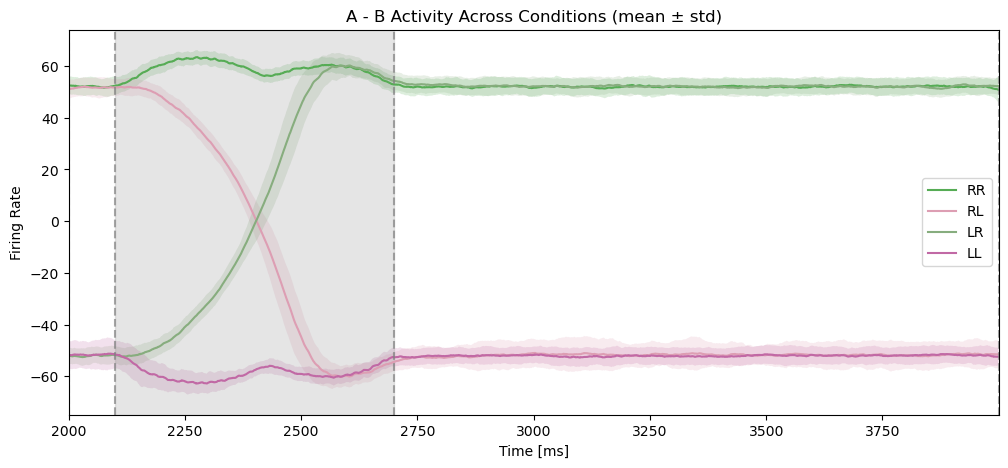

Saved: 0512__avg_hb_AB_with_std_full.pdf
Saved: 0512__avg_hb_AB_with_std_half.pdf


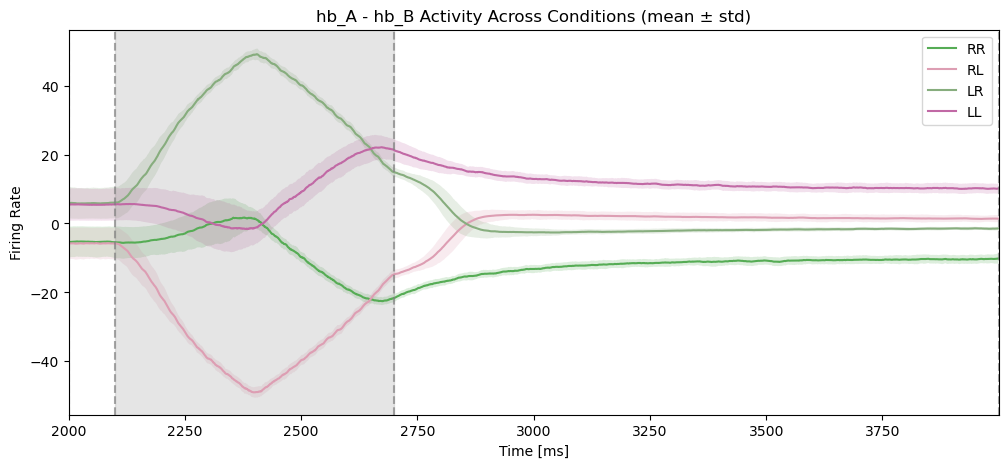

In [ ]:
# ======================
# Parameters & global settings
# ======================
dt = bm.get_dt()
pre_stimulus_period = 100.0
stimulus_period = 600.0
delay_period = 1300.0
unique_conds = ['RR', 'RL', 'LR', 'LL']

color_map = {
    'RR': '#56ac55',
    'LR': '#87ad7e',
    'RL': '#dd9eb3',
    'LL': '#c169a5'
}

# ======================
# Data loading and condition handling
# ======================
def load_data(file_index):
    avg_rates = np.load(f'0321_average_rates{file_index:02d}.npy', allow_pickle=True).item()
    seqs = np.load(f'0321_seqs{file_index:02d}.npy', allow_pickle=True)
    return avg_rates, seqs

def get_trial_condition(trial_i, seqs):
    return 'X' + seqs[trial_i] if trial_i == 0 else seqs[trial_i - 1] + seqs[trial_i]

# ======================
# Plotting utility functions
# ======================
def add_trial_lines(ax, trial_len):
    points = [
        pre_stimulus_period,
        pre_stimulus_period + stimulus_period,
        pre_stimulus_period + stimulus_period + delay_period
    ]
    for p in points:
        ax.axvline(p, linestyle='--', color='gray', alpha=0.7)
        ax.axvline(p + trial_len * dt, linestyle='--', color='gray', alpha=0.7)

def fill_stimulus(ax, trial_len):
    ymin, ymax = ax.get_ylim()
    for shift in [0, trial_len * dt]:
        ax.fill_betweenx([ymin, ymax],
                         shift + pre_stimulus_period,
                         shift + pre_stimulus_period + stimulus_period,
                         color='grey', alpha=0.2)

def compute_y_range(traj_dict):
    all_vals = np.concatenate([np.array(traj_dict[c]) for c in unique_conds if traj_dict[c]], axis=0)
    ymin, ymax = np.min(all_vals), np.max(all_vals)
    margin = 0.01 * (ymax - ymin)
    return ymin - margin, ymax + margin

def plot_avg_trajectory_with_std(time, trial_len, data_dict, ylims, title, ylabel, filename_base):
    fig, ax = plt.subplots(figsize=(12, 5))
    downsample_step = 5  # Adjust depending on data density
    time_ds = time[::downsample_step]
    for cond in unique_conds:
        if data_dict[cond]:
            data = np.array(data_dict[cond])
            mean_curve = np.mean(data, axis=0)
            std_curve = np.std(data, axis=0)
            mean_ds = mean_curve[::downsample_step]
            std_ds = std_curve[::downsample_step]
            ax.plot(time_ds, mean_ds, label=cond, color=color_map[cond])
            ax.fill_between(
                time_ds, 
                mean_ds - std_ds, 
                mean_ds + std_ds,
                color=color_map[cond], 
                alpha=0.2,  # reduce transparency
                edgecolor="none",
                linewidth=0
            )
    ax.set_title(title)
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylims)
    add_trial_lines(ax, trial_len)
    fill_stimulus(ax, trial_len)
    ax.legend()
    # plt.tight_layout()
    

    # Save full plot
    full_path = f'{filename_base}_full.pdf'
    plt.savefig(full_path, bbox_inches='tight')
    print(f"Saved: {full_path}")

    # Save cropped (second half) plot
    ax.set_xlim(time[trial_len], time[-1])
    half_path = f'{filename_base}_half.pdf'
    plt.savefig(half_path, bbox_inches='tight')
    print(f"Saved: {half_path}")

    plt.show()


# ======================
# Data processing & plotting calls
# ======================
traj_A_B = {cond: [] for cond in unique_conds}
traj_hb_A_B = {cond: [] for cond in unique_conds}

for data_i in range(1, 4):
    avg_rates, seqs = load_data(data_i)
    A_B = avg_rates['A'] - avg_rates['B']
    hb_A_B = avg_rates['hb_A'] - avg_rates['hb_B']

    one_trial = A_B.shape[0] // 201
    for i in range(201):
        cond = get_trial_condition(i, seqs)
        if cond not in unique_conds:
            continue
        start = (i - 1) * one_trial
        end = (i + 1) * one_trial
        traj_A_B[cond].append(A_B[start:end])
        traj_hb_A_B[cond].append(hb_A_B[start:end])

time_vec = np.arange(one_trial * 2) * dt

# Plotting
ylims_AB = compute_y_range(traj_A_B)
ylims_hbAB = compute_y_range(traj_hb_A_B)

plot_avg_trajectory_with_std(time_vec, one_trial, traj_A_B, ylims_AB,
                             'A - B Activity Across Conditions (mean ± std)',
                             'Firing Rate', '0512_avg_AB_with_std')

plot_avg_trajectory_with_std(time_vec, one_trial, traj_hb_A_B, ylims_hbAB,
                             'hb_A - hb_B Activity Across Conditions (mean ± std)',
                             'Firing Rate', '0512_avg_hb_AB_with_std')


Saved: 0512_avg_inp_AB_with_std_full.pdf
Saved: 0512_avg_inp_AB_with_std_half.pdf


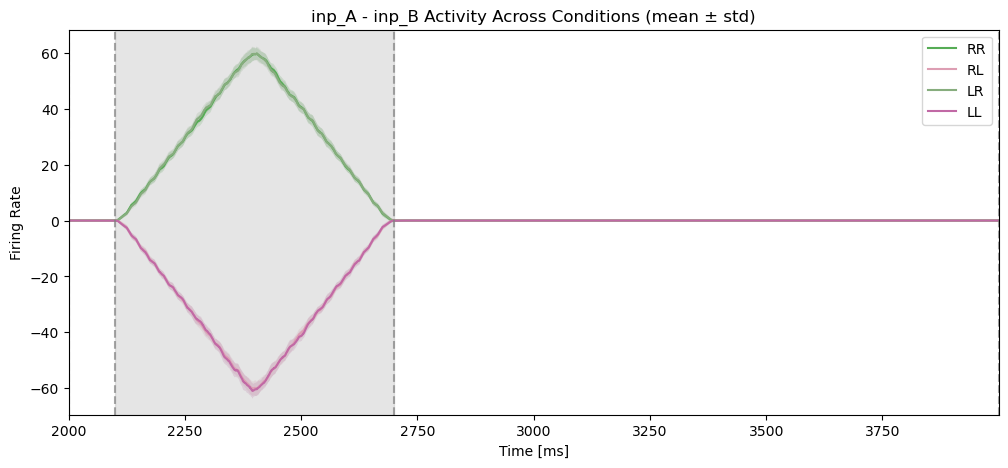

In [ ]:
# ======================
# Data processing & plotting calls
# ======================

def load_data(file_index):
    avg_rates = np.load(f'0331_input_average_rates{file_index:02d}.npy', allow_pickle=True).item()
    seqs = np.load(f'0331_input_seqs{file_index:02d}.npy', allow_pickle=True)
    return avg_rates, seqs

traj_inp_A_B = {cond: [] for cond in unique_conds}

for data_i in [1]:
    avg_rates, seqs = load_data(data_i)
    inp_A_B = avg_rates['Inp_A'] - avg_rates['Inp_B']


    one_trial = inp_A_B.shape[0] // 201
    for i in range(201):
        cond = get_trial_condition(i, seqs)
        if cond not in unique_conds:
            continue
        start = (i - 1) * one_trial
        end = (i + 1) * one_trial
        traj_inp_A_B[cond].append(inp_A_B[start:end])

time_vec = np.arange(one_trial * 2) * dt

# plot
ylims_inp_AB = compute_y_range(traj_inp_A_B)


plot_avg_trajectory_with_std(time_vec, one_trial, traj_inp_A_B, ylims_inp_AB,
                             'inp_A - inp_B Activity Across Conditions (mean ± std)',
                             'Firing Rate', '0512_avg_inp_AB_with_std')

